<font size="4">  Script to run hyperspectral reflectance model from Kramer et al. (2022). Ported from Matlab by A. Windle in October 2023
<br> <font size="3"> This script runs one Rrs spectra at a time and allows you to see intermediate steps. Please see Kramer_hyperRrs_loop.ipynb to run the code on many Rrs spectra

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Kramer_functions import *

import warnings
warnings.filterwarnings('ignore')

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


<font size="4"> Input data

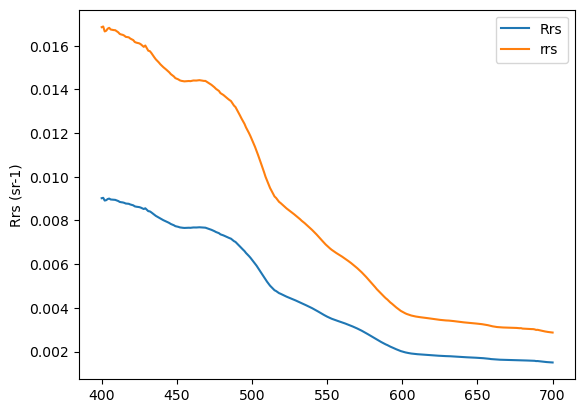

In [2]:
wave = np.arange(400, 701, 1)
chl = 0.228
T = 27.6949
S = 35.6639

#asw_data and coeff_data from Kramer github
asw_data = pd.read_csv('/Users/awindled/Documents/Kramer_code/Rrs_pigments/aw_mcf16_350_700_1nm.csv')
asw_data = asw_data.rename(columns={"Lambda": "wv"}).set_index('wv')
asw = asw_data.iloc[50:].values # subset for your wavelengths (400-700)
coeff_data = pd.read_csv('/Users/awindled/Documents/Kramer_code/Rrs_pigments/aph_A_B_Coeffs_Sasha_RSE_paper.csv').replace(',','', regex=True).astype(float)
coeff_data = coeff_data.rename(columns={"wavelength,": "wv", "A,": "A"}).set_index('wv')

#read in Rrs data 
dat = pd.read_csv('/Users/awindled/Documents/Shearwater_Cruise/trios_data/20210827_transect3_mean_std.csv', index_col=0)

#select one column
Rrs = dat['Offshore mean'].loc[400:700,]
wave = np.arange(400, 701, 1)
plt.plot(wave, Rrs, label='Rrs')

#The model uses reflectance = f(IOPs) from Gordon et al. (1988) which uses
#below the surface reflectance (rrs = Lu(0-)/Ed(0-)). If you are using 
#above surface reflectance (Rrs = Lu(0+)/Ed(0+)), you will need to convert
#your reflectances before running this model, using the equation below from
#Lee et al. (2002) (rrs = Rrs/(0.52 + 1.7*Rrs))

rrs = Rrs/(0.52 + 1.7*Rrs)

plt.plot(wave, rrs, label='rrs')
plt.ylabel('Rrs (sr-1)')
plt.legend()

<font size="4"> Rrs is a function of IOPs, specifically absorption and backscattering. Here, you will build the absorption and backscattering terms from their component parts.

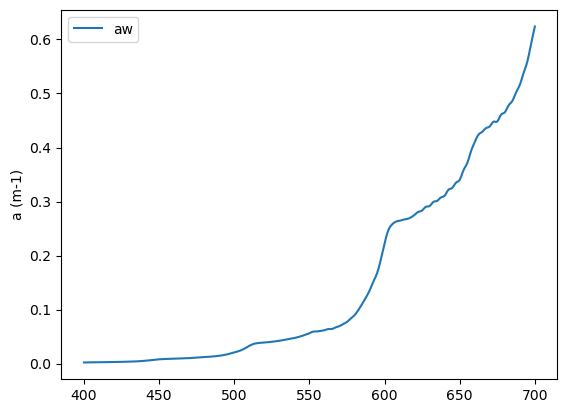

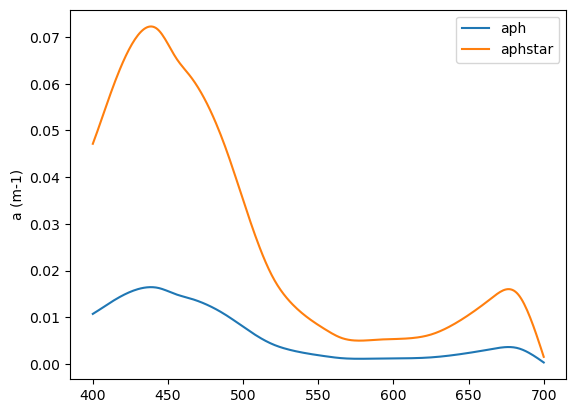

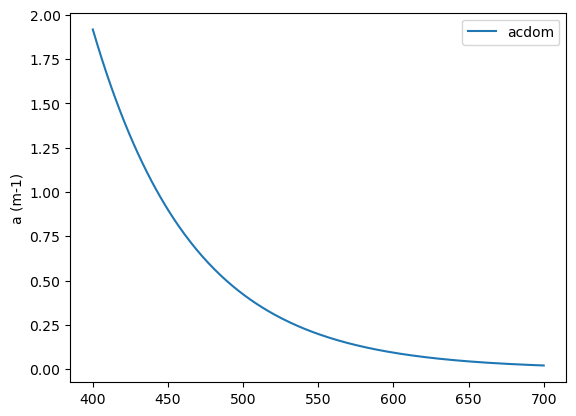

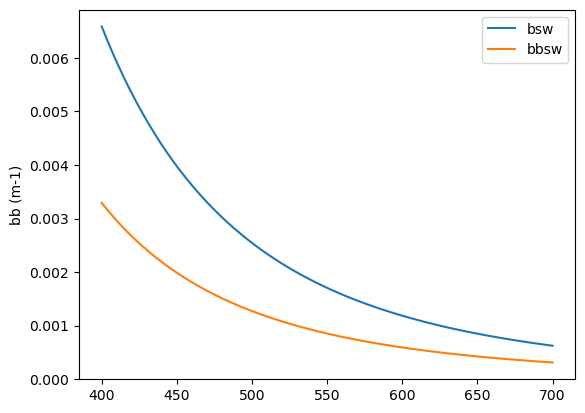

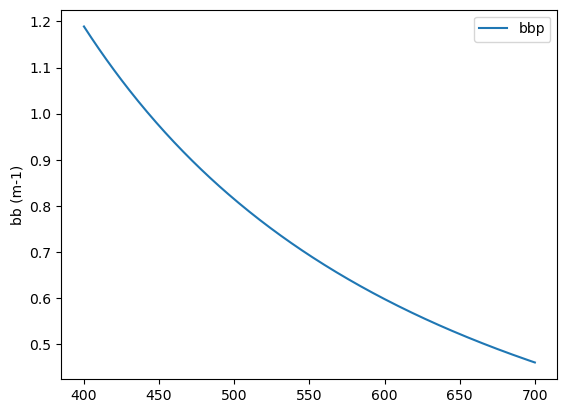

In [3]:
# First, define total absorption as a sum of seawater absorption (asw),
# phytoplankton absorption (aph) and CDOM plus other detrital matter (acdm)
# a_tot = asw + aphstar + acdm
asw = asw_data.iloc[50:].values # subset for your wavelengths (400-700)
plt.plot(wave, asw, label='aw')
plt.ylabel('a (m-1)')
plt.legend()

# aphstar = aph/chl --> aph = import A & B coefficients from aph_A_B_Coeffs_Sasha_RSE_paper.txt
A = coeff_data.iloc[50:, 0].values #subsets to 400-700 wl (gets rid of first 50)
B = coeff_data.iloc[50:, 1].values
aph = A * chl**B
aphstar = aph / chl
plt.figure(2)
plt.plot(wave, aph, label='aph')
plt.plot(wave, aphstar, label='aphstar')
plt.ylabel('a (m-1)')
plt.legend()

# Calculate acdm
acdm_s = -(0.01447 + 0.00033 * Rrs.loc[490] / Rrs.loc[555])
acdm = np.exp(acdm_s * (wave - 443))
plt.figure(3)
plt.plot(wave, acdm, label='acdom')
plt.ylabel('a (m-1)')
plt.legend()

#Then, define backscattering as a sum of seawater backscattering (bbsw) and backscattering by particles (bbp)
#bb_tot = bbsw + bbp
#bsw comes from Zhang et al. (2009):
bsw = betasw_ZHH2009(wave,T,[],S)
bbsw = 0.5*bsw[2]
plt.figure(4)
plt.plot(wave, bsw[2], label='bsw')
plt.plot(wave, bbsw, label='bbsw')
plt.ylabel('bb (m-1)')
plt.legend()

# bbp slope is a function of rrs (just below surface)
bbp_s = 2.0 * (1.0 - 1.2 * np.exp(-0.9 * rrs.loc[440] / rrs.loc[555]))
bbp = (443 / wave) ** bbp_s
plt.figure(5)
plt.plot(wave, bbp, label='bbp')
plt.ylabel('bb (m-1)')
plt.legend()


<font size="4"> Run hyperspectral reflectance model from Kramer et al. (2022) <font size="3"> <br> Runs with: betasw_ZHH2009.m, gsm_invert.m, gsm_cost.m <br>
<font size="3"> Inputs: measured Rrs, chl, temp, sal, asw, A&B coeffs for aph <br>
<font size="3"> Outputs: chl, acdm443, bbp443

In [4]:
IOPs = gsm_invert(rrs, asw[:,0], bbsw, bbp, A, B, acdm)
IOPs

Optimization terminated successfully.
         Current function value: 0.000686
         Iterations: 215
         Function evaluations: 395


array([0.47470766, 0.01517435, 0.00563228])

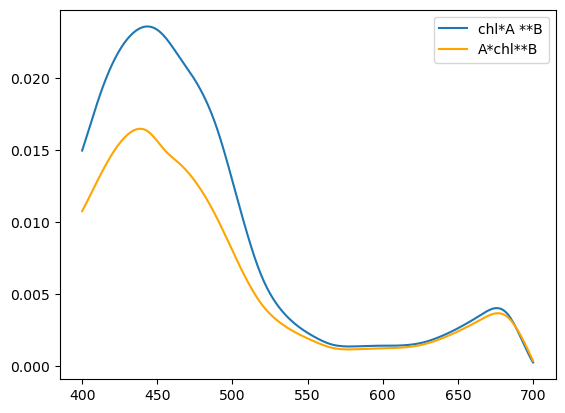

In [16]:
plt.plot(wave, chl*A **B, label='chl*A **B')
plt.plot(wave, A*chl**B, color='orange', label='A*chl**B')
plt.legend()

<font size="4"> Plot specific absorption and backscattering 

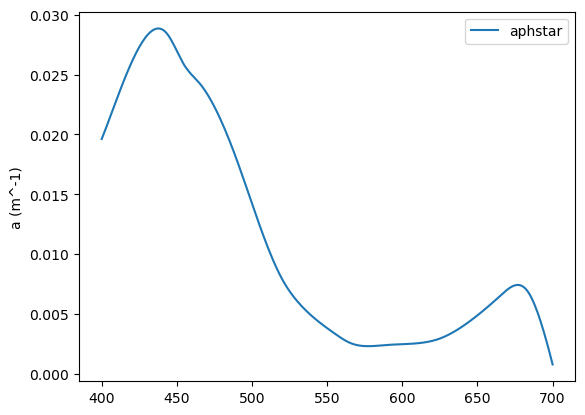

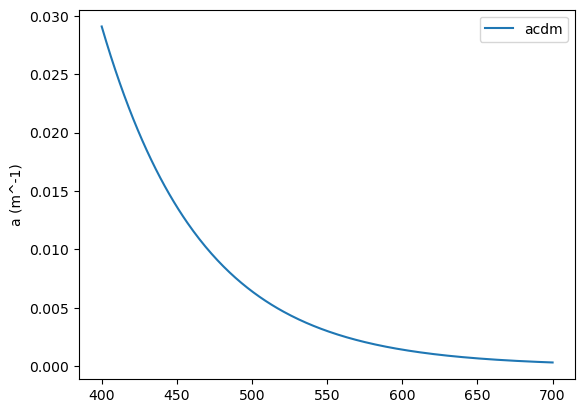

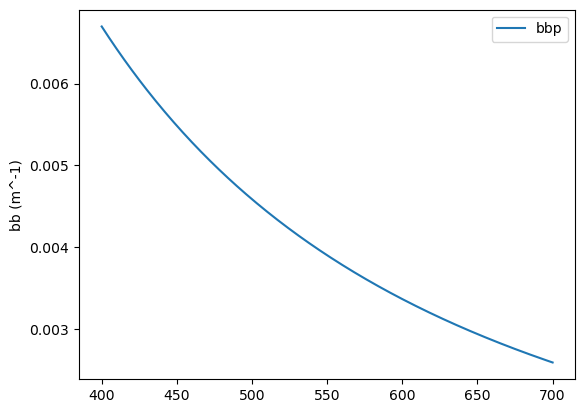

In [5]:
#aphstar
plt.plot(wave, A * IOPs[0]**B, label='aphstar')
plt.ylabel('a (m^-1)')
plt.legend()

#acdm
plt.figure(2)
plt.plot(wave, IOPs[1] * acdm, label='acdm')
plt.ylabel('a (m^-1)')
plt.legend()

#bbp
plt.figure(3)
plt.plot(wave, IOPs[2] * bbp, label='bbp')
plt.ylabel('bb (m^-1)')
plt.legend()

<font size="4"> Reconstruct Rrs and then compare the modeled spectra to the measured spectra

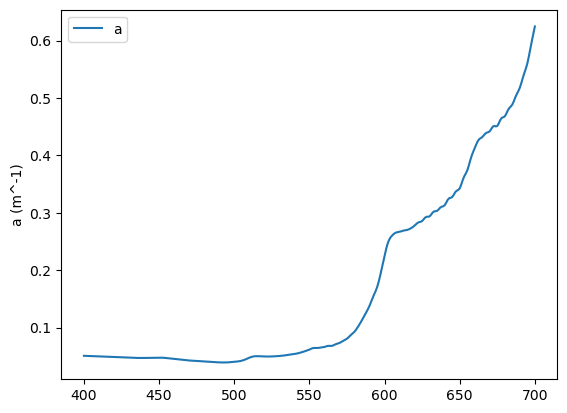

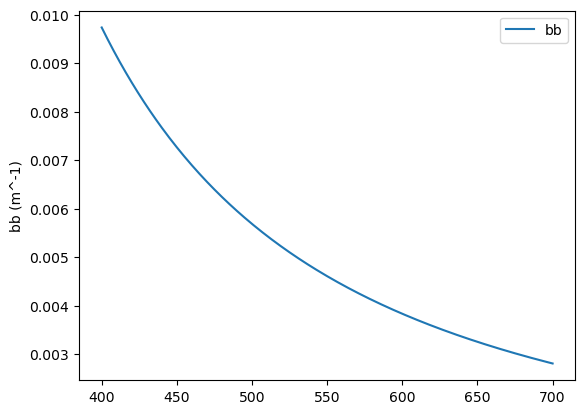

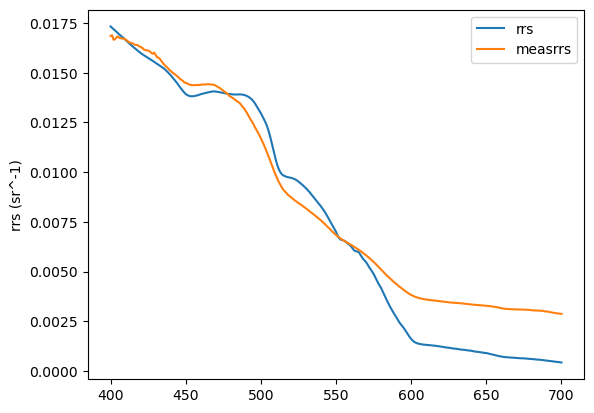

In [5]:
#a = asw[:,0] + A*IOPs[0]**B + IOPs[1] * acdm
#a = asw[:,0] + IOPs[0] * A**B + IOPs[1] * acdm
a = asw[:,0] + (A*IOPs[0])**B + IOPs[1] * acdm
plt.plot(wave, a, label='a')
plt.ylabel('a (m^-1)')
plt.legend()

bb = bbsw + IOPs[2] * bbp
plt.figure(2)
plt.plot(wave, bb, label='bb')
plt.ylabel('bb (m^-1)')
plt.legend()

rrsP = bb / (a + bb)
#apply coefficients from Gordon et al. (1988)
g = np.array([0.0949, 0.0794])  
modrrs = g[0] * rrsP + g[1] * rrsP*rrsP
plt.figure(3)
plt.plot(wave, modrrs, label='rrs')
plt.plot(wave, rrs, label='measrrs')
plt.ylabel('rrs (sr^-1)')
plt.legend()


<font size="4"> Calculate residual between measured and modeled

(-0.02, 0.01)

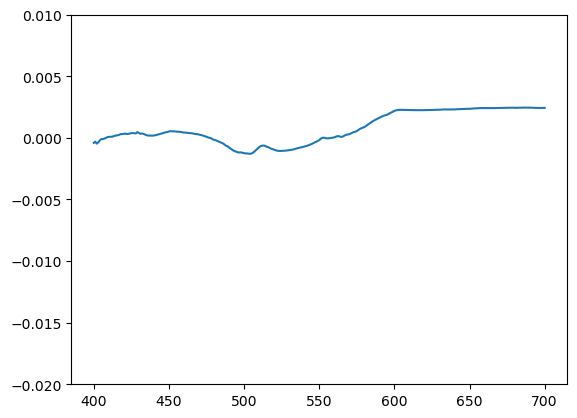

In [10]:
rrsD = rrs - modrrs
plt.plot(wave, rrsD)
plt.ylim(-0.02, 0.01)

<font size="4"> Calculate 1st and 2nd derivative of Rrs residual

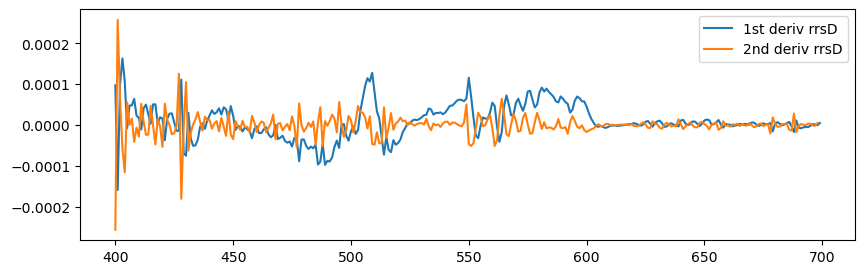

In [11]:
rrsD1 = np.diff(rrsD, axis=0)
rrsD2 = np.diff(rrsD1, axis=0)

plt.figure(figsize=(10,3))
plt.plot(wave[:-1], rrsD1, label='1st deriv rrsD')
plt.plot(wave[:-2], rrsD2, label='2nd deriv rrsD')
plt.legend()

<font size="4"> Save modeled Rrs, Rrs residual, and 1st and 2nd deriative of Rrs redisual

In [70]:
dat = pd.DataFrame([wave, np.array(rrs), modrrs, rrsD, rrsD1, rrsD2]).T
dat = dat.rename(columns={0:"wave", 1: "measrrs", 2: "modrrs", 3:"rrsD", 4:"rrsD1", 5:"rrsD2"})
dat = dat.set_index('wave')

dat.to_csv('/Users/awindled/Documents/Kramer_code/Rrs_pigments/20210827_transect3_rrsD.csv')
dat

,measrrs,modrrs,rrsD,rrsD1,rrsD2
wave,,,,,
400.0,0.016851,0.017485,-0.000634,1.137124e-04,-2.568851e-04
401.0,0.016882,0.017402,-0.000521,-1.431727e-04,2.570744e-04
402.0,0.016655,0.017318,-0.000664,1.139016e-04,6.367017e-05
403.0,0.016686,0.017236,-0.000550,1.775718e-04,-5.565764e-05
404.0,0.016781,0.017154,-0.000372,1.219142e-04,-1.158785e-04
...,...,...,...,...,...
696.0,0.002906,0.000484,0.002422,2.238856e-06,-7.593790e-07
697.0,0.002896,0.000472,0.002424,1.479477e-06,-1.678256e-06
698.0,0.002886,0.000460,0.002426,-1.987786e-07,5.218096e-06
